In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import scipy.io as sio

2023-07-26 10:57:10.369172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 10:57:12.064914: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 10:57:12.561397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/li

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6570655950883539414
xla_global_id: -1
]


2023-07-26 10:57:40.908489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 10:57:40.996945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 10:57:40.997412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-07-26 10:57:4

In [3]:
def min_max_scaling(arr):
    """
    Perform Min-Max scaling on the input array.

    Parameters:
        arr (numpy array): The input array to be normalized.

    Returns:
        numpy array: The normalized array.
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr



mat_data = sio.loadmat('/home/macula/SMATousi/VAE_outlier/Matlab/mnist.mat')

mnist_data = mat_data['X']

normalized_array = min_max_scaling(mnist_data)
print(normalized_array)

[[0.35042224 0.16178682 0.85704909 ... 0.35042978 0.3188614  0.35043144]
 [0.35042224 0.16178682 0.85449308 ... 0.35042978 0.3188614  0.35043144]
 [0.35042224 0.16178682 0.21293302 ... 0.35042978 0.3188614  0.35043144]
 ...
 [0.35042224 0.16178682 0.21293302 ... 0.35042978 0.3188614  0.35043144]
 [0.35042224 0.16178682 0.21293302 ... 0.35042978 0.67159164 0.35043144]
 [0.35042224 0.23079926 0.21293302 ... 0.35042978 0.3188614  0.35043144]]


In [4]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 128

encoder_inputs = keras.Input(shape=(100,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(100, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
#             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
#             
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# mnist_data = mat_data['X']
tdata = np.concatenate([normalized_array], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
history = vae.fit(tdata, epochs=30, batch_size=1024)

2023-07-26 10:57:52.470164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-26 10:57:52.470474: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
8/8 [==============================] - 1s 25ms/step - loss: 0.1581 - reconstruction_loss: 0.1211 - kl_loss: 0.0021
Epoch 2/30
8/8 [==============================] - 0s 22ms/step - loss: 0.0534 - reconstruction_loss: 0.0496 - kl_loss: 9.7134e-05
Epoch 3/30
8/8 [==============================] - 0s 22ms/step - loss: 0.0403 - reconstruction_loss: 0.0396 - kl_loss: 8.0331e-05
Epoch 4/30
8/8 [==============================] - 0s 22ms/step - loss: 0.0371 - reconstruction_loss: 0.0366 - kl_loss: 4.5082e-05
Epoch 5/30
8/8 [==============================] - 0s 21ms/step - loss: 0.0349 - reconstruction_loss: 0.0346 - kl_loss: 4.0793e-05
Epoch 6/30
8/8 [==============================] - 0s 21ms/step - loss: 0.0339 - reconstruction_loss: 0.0336 - kl_loss: 3.4414e-05
Epoch 7/30
8/8 [==============================] - 0s 22ms/step - loss: 0.0330 - reconstruction_loss: 0.0329 - kl_loss: 2.5785e-05
Epoch 8/30
8/8 [==============================] - 0s 22ms/step - loss: 0.0324 - reconstruction

In [51]:
target_labels = mat_data['y']

target_labels.shape

out_rec = []

for i in range(target_labels.shape[0]):
    
    if target_labels[i] == 0:
        
        sample = normalized_array[i,:].reshape([1,100])

        z_mean, z_log_var, z = vae.encoder(sample)
        reconstruction = vae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
        out_rec.append(reconstruction_loss.numpy())

print("Mean = ", np.mean(np.array(out_rec)))
print("Std = ", np.std(np.array(out_rec)))

Mean =  0.028302643
Std =  0.0069903038


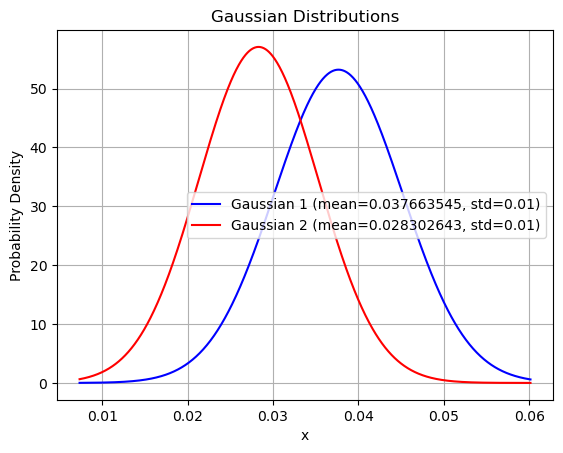

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage:
mean1 = 0.037663545
std1 = 0.0074978177
mean2 = 0.028302643
std2 = 0.0069903038

def gaussian(x, mean, std):
    """
    Compute the Gaussian probability density function.

    Parameters:
        x (numpy array): The input values.
        mean (float): Mean of the Gaussian distribution.
        std (float): Standard deviation of the Gaussian distribution.

    Returns:
        numpy array: The Gaussian probability density function values.
    """
    exponent = -0.5 * ((x - mean) / std)**2
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(exponent)

def plot_gaussian(mean1, std1, mean2, std2):
    """
    Plot two Gaussian distributions with given means and standard deviations.

    Parameters:
        mean1 (float): Mean of the first Gaussian distribution.
        std1 (float): Standard deviation of the first Gaussian distribution.
        mean2 (float): Mean of the second Gaussian distribution.
        std2 (float): Standard deviation of the second Gaussian distribution.

    Returns:
        None
    """
    x = np.linspace(min(mean1 - 3 * std1, mean2 - 3 * std2), max(mean1 + 3 * std1, mean2 + 3 * std2), 1000)
    gaussian1 = gaussian(x, mean1, std1)
    gaussian2 = gaussian(x, mean2, std2)

    plt.plot(x, gaussian1, label=f"Gaussian 1 (mean={mean1}, std={std1:.2f})", color='blue')
    plt.plot(x, gaussian2, label=f"Gaussian 2 (mean={mean2}, std={std2:.2f})", color='red')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title('Gaussian Distributions')
    plt.legend()
    plt.grid(True)
    plt.show()



plot_gaussian(mean1, std1, mean2, std2)


In [54]:
normalized_array[0,:]

array([0.35042224, 0.16178682, 0.85704909, 0.35043144, 0.3168847 ,
       0.34749176, 0.35043144, 0.35006942, 0.80859578, 0.64350723,
       0.14406712, 0.68439885, 0.76616707, 0.5492648 , 0.32530912,
       0.35023616, 0.34112847, 0.06576322, 0.23018676, 0.65373176,
       0.87139209, 0.35043144, 0.32518711, 0.62911047, 0.82599663,
       0.18174851, 0.3504003 , 0.59592959, 0.35014465, 0.35037474,
       0.34112741, 0.35021933, 0.77389042, 0.72718876, 0.23743925,
       0.34994754, 0.35034142, 0.35043144, 0.31876159, 0.34967443,
       0.34908702, 0.33346175, 0.30741978, 0.27917896, 0.3498128 ,
       0.2201711 , 0.29641455, 0.29487779, 0.2699159 , 0.3455802 ,
       0.34957257, 0.75520591, 0.35038215, 0.35040375, 0.34827501,
       0.35012437, 0.34833474, 0.12625242, 0.31688743, 0.72742238,
       0.35043007, 0.35043144, 0.35038479, 0.34735881, 0.30877907,
       0.10258336, 0.80889836, 0.61826041, 0.32359825, 0.31968022,
       0.35042982, 0.12839721, 0.35043144, 0.13208234, 0.26223

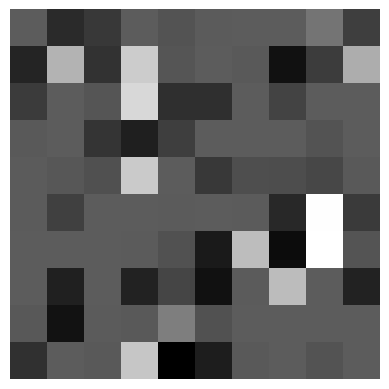

In [7]:

def plot_mnist(mnist_array):
    if len(mnist_array) != 100:
        raise ValueError("The length of the 1D array must be 100 to represent a 2D image.")

    # Reshape the 1D MNIST array into a 2D array of shape (10, 10)
    mnist_2d = mnist_array.reshape(10, 10)

    # Plot the 2D MNIST array
    plt.imshow(mnist_2d, cmap='gray')
    plt.axis('off')
    plt.show()

# Replace this with your actual MNIST data in the form of a 1D array of length 100
# For example, mnist_array = np.array([...])
mnist_array = np.random.rand(100)  # Just a random array for demonstration

plot_mnist(normalized_array[7100,:])

# Genetic Part

In [8]:
sols = []

wandb.init(
    # set the wandb project where this run will be logged
    project="VAE_Outlier_GA_MNIST_subspace_detection_1",
    
    # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 20,
#     }
)

for out_number in range(100):

    def fitness_func_avg(ga_instance, solution, solution_idx):

        inliers = normalized_array[10:16,:]

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,100])

        particle = normalized_array[7100 + out_number ,:]
        particle = particle.reshape([1,100])

    #     abn_subspace = solution * val_features[6728,:]

    #     abn_subspace = abn_subspace.reshape([1,30])

        avg_in_rec = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,100])

            in_remain = candidate_inlier * solution

            in_normal_subspace = 1 - solution

            in_replace = in_normal_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z_mean, z_log_var, z = vae.encoder(in_candidate)
            in_candidate_rec = vae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

            avg_in_rec.append(rec_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_remain = particle * solution

        out_normal_subspace = 1 - solution

        out_replace = avg_ins * out_normal_subspace

        out_candidate = out_remain + out_replace


        z_mean, z_log_var, z = vae.encoder(out_candidate)
        out_candidate_rec = vae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        fitness = rec_loss / avg_in_rec

        return fitness


    # def fitness_func_avg_with_penalty(ga_instance, solution, solution_idx):

    #     inliers = corrupted_data[10:13,:]

    #     avg_ins = np.mean(inliers, axis=0)
    #     avg_ins = avg_ins.reshape([1,30])

    #     particle = corrupted_data[201,:]
    #     particle = particle.reshape([1,30])

    # #     abn_subspace = solution * val_features[6728,:]

    # #     abn_subspace = abn_subspace.reshape([1,30])

    #     avg_in_rec = []

    #     for index in range(inliers.shape[0]):

    #         candidate_inlier = inliers[index,:]
    #         candidate_inlier = candidate_inlier.reshape([1,30])

    #         in_remain = candidate_inlier * solution

    #         in_normal_subspace = 1 - solution

    #         in_replace = in_normal_subspace * avg_ins

    #         in_candidate = in_remain + in_replace

    #         z_mean, z_log_var, z = vae.encoder(in_candidate)
    #         in_candidate_rec = vae.decoder(z)


    #         rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

    #         avg_in_rec.append(rec_loss.numpy())

    #     avg_in_rec = np.array(avg_in_rec)
    #     avg_in_rec = np.mean(avg_in_rec)





    # #     z_mean, z_log_var, z = vae.encoder(particle)
    # #     reconstruction_1 = vae.decoder(z)

    #     out_remain = particle * solution

    #     out_normal_subspace = 1 - solution

    #     out_replace = avg_ins * out_normal_subspace

    #     out_candidate = out_remain + out_replace


    #     z_mean, z_log_var, z = vae.encoder(out_candidate)
    #     out_candidate_rec = vae.decoder(z)

    #     rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    #     rec_loss = rec_loss.numpy()

    #     fitness = rec_loss / avg_in_rec

    #     # adding the penalty here!

    #     num_ones = np.count_nonzero(solution == 1)

    #     penalty_rate = 1.0/corrupted_data.shape[1]

    #     fitness = fitness - num_ones * penalty_rate * fitness

    #     return fitness

    def on_generation(ga):
        print("Generation", ga.generations_completed)

        solution, solution_fitness, solution_idx = ga_instance.best_solution()

        print(solution_fitness)


    fitness_function = fitness_func_avg

    num_generations = 100
    num_parents_mating = 4

    sol_per_pop = 100
    num_genes = normalized_array.shape[1]

    init_range_low = -2
    init_range_high = 5

    parent_selection_type = "sss"
    keep_parents = 1

    space = [[0,1] for i in range(num_genes)]

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 10

    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           #keep_parents=keep_parents,
                           keep_elitism=2,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           on_generation=on_generation,
                           gene_space = space)
    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^ ", out_number, " ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    
    wandb.log({"Solution/subspace": solution})
    
    sols.append(solution)
    

wandb: Currently logged in as: stmmc (tousi-team). Use `wandb login --relogin` to force relogin


Generation 1
2.3369067
Generation 2
2.6092386
Generation 3
2.6493056
Generation 4
2.752201
Generation 5
2.828349
Generation 6
3.124829
Generation 7
3.124829
Generation 8
3.124829
Generation 9
3.124829
Generation 10
3.124829
Generation 11
3.124829
Generation 12
3.124829
Generation 13
3.124829
Generation 14
3.124829
Generation 15
3.208263
Generation 16
3.124829
Generation 17
3.124829
Generation 18
3.124829
Generation 19
3.124829
Generation 20
3.124829
Generation 21
3.167287
Generation 22
3.1926897
Generation 23
3.1926897
Generation 24
3.1926897
Generation 25
3.2949562
Generation 26
3.2949562
Generation 27
3.2949562
Generation 28
3.2949562
Generation 29
3.2949562
Generation 30
3.2949562
Generation 31
3.2949562
Generation 32
3.2949562
Generation 33
3.323066
Generation 34
3.407726
Generation 35
3.407726
Generation 36
3.407726
Generation 37
3.407726
Generation 38
3.6637764
Generation 39
3.6637764
Generation 40
3.6637764
Generation 41
3.6637764
Generation 42
3.6637764
Generation 43
3.6637764


Generation 1
2.7858303
Generation 2
2.8265154
Generation 3
3.0388994
Generation 4
3.1896713
Generation 5
3.376657
Generation 6
3.4602308
Generation 7
3.6768794
Generation 8
3.6993039
Generation 9
3.6285574
Generation 10
3.7268524
Generation 11
4.0982585
Generation 12
4.3058667
Generation 13
3.9378633
Generation 14
3.9378633
Generation 15
3.958945
Generation 16
3.9857562
Generation 17
4.14119
Generation 18
3.9857562
Generation 19
3.9857562
Generation 20
3.9857562
Generation 21
3.9857562
Generation 22
4.156747
Generation 23
3.9857562
Generation 24
4.2238746
Generation 25
4.2238746
Generation 26
4.2238746
Generation 27
4.2238746
Generation 28
4.306992
Generation 29
4.2238746
Generation 30
4.2238746
Generation 31
4.2238746
Generation 32
4.2238746
Generation 33
4.2238746
Generation 34
4.2238746
Generation 35
4.2238746
Generation 36
4.2238746
Generation 37
4.2238746
Generation 38
4.2238746
Generation 39
4.2238746
Generation 40
4.2238746
Generation 41
4.2238746
Generation 42
4.2238746
Generat

Generation 1
2.4149892
Generation 2
2.8664021
Generation 3
2.8664021
Generation 4
3.043935
Generation 5
2.9488492
Generation 6
3.0471196
Generation 7
3.0056772
Generation 8
3.05551
Generation 9
3.05551
Generation 10
3.05551
Generation 11
3.1114297
Generation 12
3.0597937
Generation 13
3.3005607
Generation 14
3.4476147
Generation 15
3.4476147
Generation 16
3.4476147
Generation 17
3.4476147
Generation 18
3.4476147
Generation 19
3.4476147
Generation 20
3.4476147
Generation 21
3.4476147
Generation 22
3.4476147
Generation 23
3.4476147
Generation 24
3.4476147
Generation 25
3.4476147
Generation 26
3.4476147
Generation 27
3.4476147
Generation 28
3.4476147
Generation 29
3.4476147
Generation 30
3.4476147
Generation 31
3.4476147
Generation 32
3.4476147
Generation 33
3.4476147
Generation 34
3.4476147
Generation 35
3.4476147
Generation 36
3.4476147
Generation 37
3.4476147
Generation 38
3.4476147
Generation 39
3.4476147
Generation 40
3.4476147
Generation 41
3.4476147
Generation 42
3.4476147
Generati

Generation 1
2.1854653
Generation 2
2.4360368
Generation 3
2.53969
Generation 4
2.6527724
Generation 5
3.0010464
Generation 6
2.7875082
Generation 7
2.9746137
Generation 8
3.0779865
Generation 9
3.0779865
Generation 10
3.1724198
Generation 11
3.1724198
Generation 12
3.1724198
Generation 13
3.294682
Generation 14
3.285519
Generation 15
3.285519
Generation 16
3.285519
Generation 17
3.4015598
Generation 18
3.4015598
Generation 19
3.4344888
Generation 20
3.4344888
Generation 21
3.4344888
Generation 22
3.4344888
Generation 23
3.4344888
Generation 24
3.4344888
Generation 25
3.4344888
Generation 26
3.4344888
Generation 27
3.4344888
Generation 28
3.4344888
Generation 29
3.4344888
Generation 30
3.4344888
Generation 31
3.4344888
Generation 32
3.4344888
Generation 33
3.4344888
Generation 34
3.4344888
Generation 35
3.4344888
Generation 36
3.4344888
Generation 37
3.4344888
Generation 38
3.4344888
Generation 39
3.4344888
Generation 40
3.4344888
Generation 41
3.4344888
Generation 42
3.4344888
Generat

Generation 1
2.3875072
Generation 2
2.9729106
Generation 3
2.740946
Generation 4
3.1023324
Generation 5
2.8815684
Generation 6
2.8927958
Generation 7
3.021046
Generation 8
2.9590824
Generation 9
2.9590824
Generation 10
2.9978259
Generation 11
3.038828
Generation 12
3.3316414
Generation 13
3.3316414
Generation 14
3.3316414
Generation 15
3.3316414
Generation 16
3.3316414
Generation 17
3.3699856
Generation 18
3.7412767
Generation 19
3.4093006
Generation 20
3.4093006
Generation 21
3.4093006
Generation 22
3.4093006
Generation 23
3.4517257
Generation 24
3.4517257
Generation 25
3.9665298
Generation 26
3.9665298
Generation 27
3.9665298
Generation 28
3.9665298
Generation 29
3.9665298
Generation 30
3.9665298
Generation 31
3.9665298
Generation 32
3.9665298
Generation 33
3.9665298
Generation 34
3.9665298
Generation 35
3.9665298
Generation 36
3.9665298
Generation 37
3.9665298
Generation 38
3.9665298
Generation 39
3.9665298
Generation 40
3.9665298
Generation 41
3.9665298
Generation 42
3.9665298
Gene

KeyboardInterrupt: 

Generation 1
1.9676763
Generation 2
2.138311
Generation 3
2.3552206
Generation 4
2.5832038
Generation 5
2.7715096


KeyboardInterrupt: 

In [81]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 1.]
Fitness value of the best solution = 4.452952861785889


In [67]:
sols = []

In [82]:
sols.append(solution)

In [83]:
len(sols)

4

In [86]:
normalized_array.shape

(7603, 100)